In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Projek\ AI

/content/drive/MyDrive/Projek AI


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [4]:
class Config:
    img_height = 200
    img_width = 200
    epochs = 50
    batch_size = 32
    learning_rate = 1e-3

In [5]:
dir_path = '/content/drive/MyDrive/Projek AI/Uang Baru'
image_paths = []

for dirname, _, filenames in os.walk(dir_path):
    for filename in filenames:
        image_path  = os.path.join(dirname, filename)
        image_paths.append(image_path)

In [6]:
df = pd.DataFrame({
    'path': image_paths
})

df['filename'] = df.path.apply(lambda x: x.split('/')[5])
df['nominal'] = df.path.apply(lambda x: x.split('/')[-1])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

path   filename  \
0  /content/drive/MyDrive/Projek AI/Uang Baru/100...  Uang Baru   
1  /content/drive/MyDrive/Projek AI/Uang Baru/10 ...  Uang Baru   
2  /content/drive/MyDrive/Projek AI/Uang Baru/100...  Uang Baru   
3  /content/drive/MyDrive/Projek AI/Uang Baru/5k/...  Uang Baru   
4  /content/drive/MyDrive/Projek AI/Uang Baru/100...  Uang Baru   

                       nominal  
0  UANG RUPOAH 100K  (57).jpeg  
1   UANG RUPIAH 10K  (14).jpeg  
2  UANG RUPOAH 100K  (28).jpeg  
3  UANG RUPIAH 5000 (151).jpeg  
4  UANG RUPOAH 100K  (70).jpeg

<BarContainer object of 1 artists>

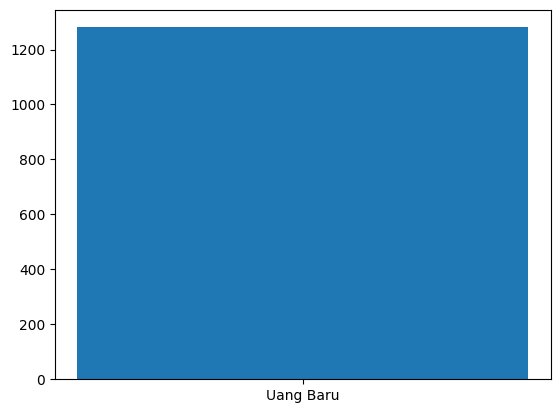

In [9]:
filename_vc = df.filename.value_counts()
plt.bar(filename_vc.index, filename_vc.values)

In [10]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=10
)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    subset='training',
    validation_split=0.2,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=Config.batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dir_path,
    subset='validation',
    validation_split=0.2,
    seed=42,
    image_size=(Config.img_height, Config.img_width),
    batch_size=Config.batch_size
)

Found 1281 files belonging to 7 classes.
Found 1281 files belonging to 7 classes.
Using 1025 files for training.
Found 1281 files belonging to 7 classes.
Using 256 files for validation.


In [11]:
currency_nominal = dataset.class_names
num_of_classes = len(currency_nominal)
currency_nominal

['10 k', '100 RB', '1k', '20 K', '2k', '50 K', '5k']

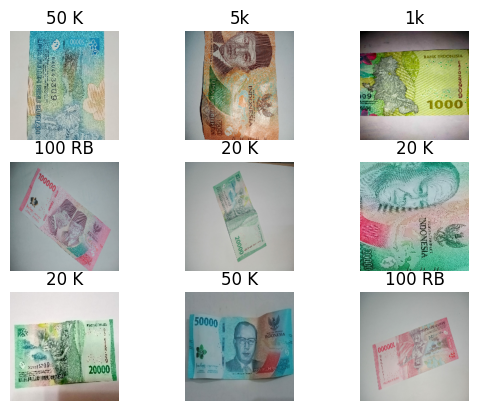

In [12]:
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(currency_nominal[labels[i]])
        plt.axis('off')

In [13]:
class myCallback(tf.keras.callbacks.Callback):
     def on_epoch_end(self, epoch,logs={}):
        if (logs.get("accuracy") > 0.90):
            print("\nStop training, accuracy > 0.90")
            self.model.stop_training = True

callback = myCallback()

In [14]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                               input_shape=(
                                   Config.img_height,
                                   Config.img_width,
                                   3)
                              ),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_of_classes)
])

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=Config.learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [17]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=Config.epochs,
    callbacks=[callback]
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 414s 12s/step - accuracy: 0.1935 - loss: 1.9144 - val_accuracy: 0.1484 - val_loss: 2.5513
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.3498 - loss: 1.7939 - val_accuracy: 0.6367 - val_loss: 0.9548
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - accuracy: 0.5069 - loss: 1.2150 - val_accuracy: 0.5664 - val_loss: 1.1221
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.6242 - loss: 0.9614 - val_accuracy: 0.7109 - val_loss: 0.7443
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.7397 - loss: 0.6737 - val_accuracy: 0.7773 - val_loss: 0.5915
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.8301 - loss: 0.5310 - val_accuracy: 0.8945 - val_loss: 0.3022
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9019 - loss: 0.2907 - val_accuracy: 0.8672 - val_loss: 0.3574
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9258 - loss: 0.2316
Stop training, accuracy > 0

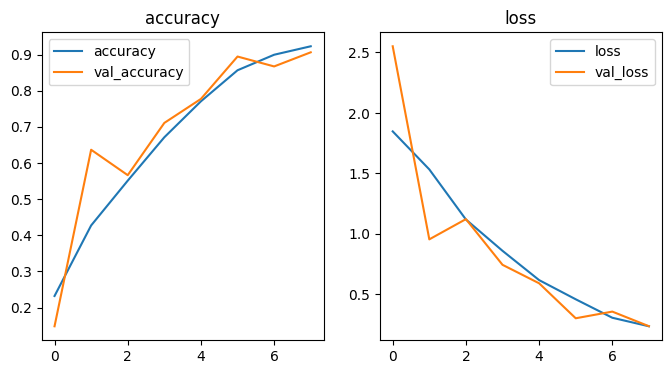

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.set_title('accuracy')
ax1.plot(model.history.history['accuracy'], label='accuracy')
ax1.plot(model.history.history['val_accuracy'], label='val_accuracy')
ax1.legend()

ax2.set_title('loss')
ax2.plot(model.history.history['loss'], label='loss')
ax2.plot(model.history.history['val_loss'], label='val_loss')
ax2.legend()

In [19]:
loss, accuracy = model.evaluate(dataset)
print('accuracy :', accuracy)
print('loss     :', loss)

129/129 ━━━━━━━━━━━━━━━━━━━━ 69s 534ms/step - accuracy: 0.9301 - loss: 0.2013
accuracy : 0.9274004697799683
loss     : 0.20393460988998413


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


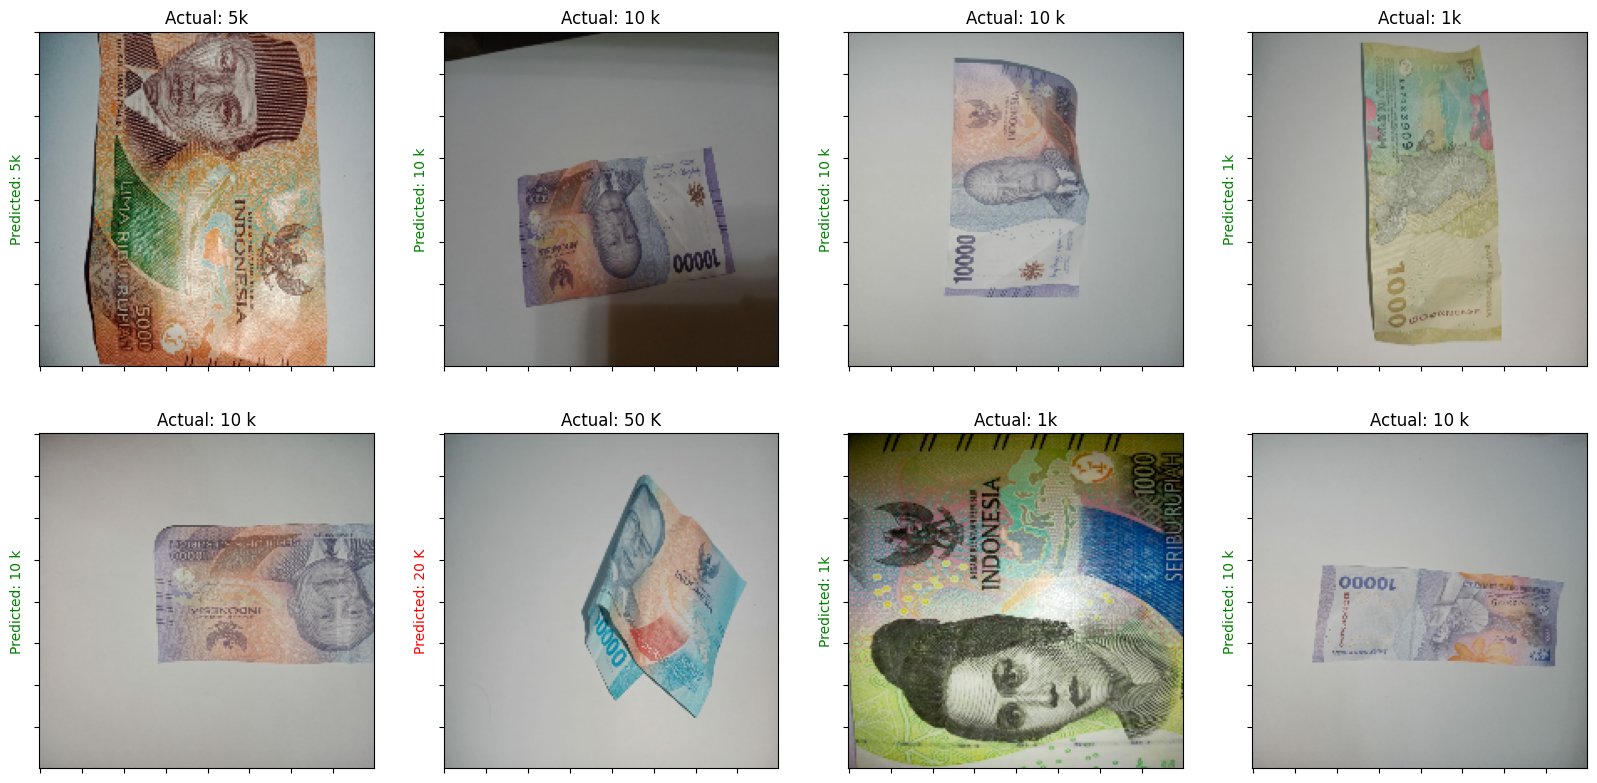

In [20]:
plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])

        predicted_axis_color = 'green' if currency_nominal[labels[i]] == currency_nominal[np.argmax(score)] else 'red'

        plt.title('Actual: ' + currency_nominal[labels[i]])
        plt.ylabel('Predicted: ' + currency_nominal[np.argmax(score)], fontdict={'color': predicted_axis_color})

        plt.gca().axes.xaxis.set_ticklabels([])
        plt.gca().axes.yaxis.set_ticklabels([])

In [23]:
model.save('model.keras')

In [26]:
model.save('/content/drive/MyDrive/Projek AI/model.keras')  # Menggunakan format Keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


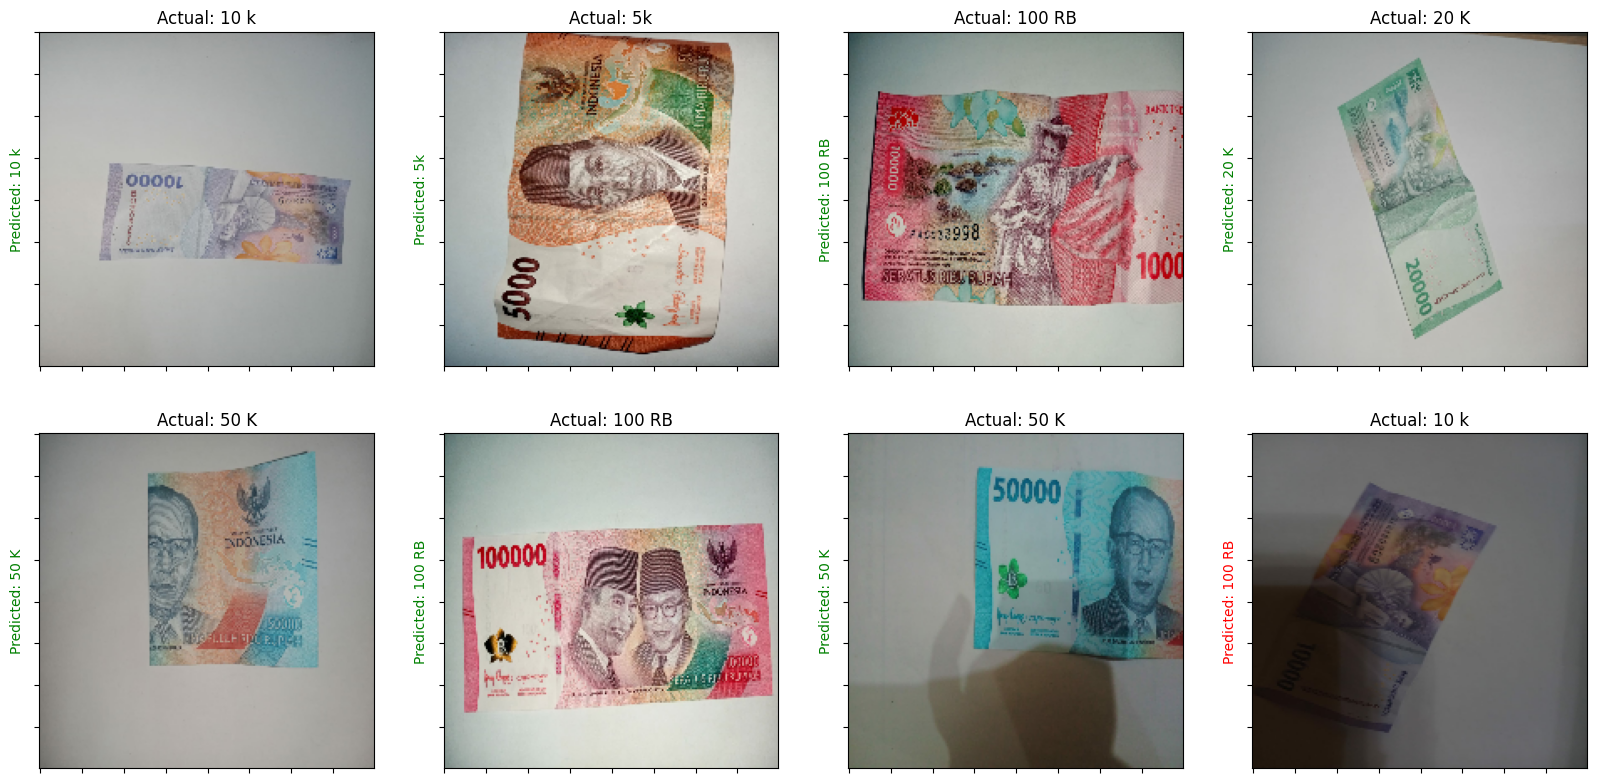

In [27]:
plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])

        predicted_axis_color = 'green' if currency_nominal[labels[i]] == currency_nominal[np.argmax(score)] else 'red'

        plt.title('Actual: ' + currency_nominal[labels[i]])
        plt.ylabel('Predicted: ' + currency_nominal[np.argmax(score)], fontdict={'color': predicted_axis_color})

        plt.gca().axes.xaxis.set_ticklabels([])
        plt.gca().axes.yaxis.set_ticklabels([])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


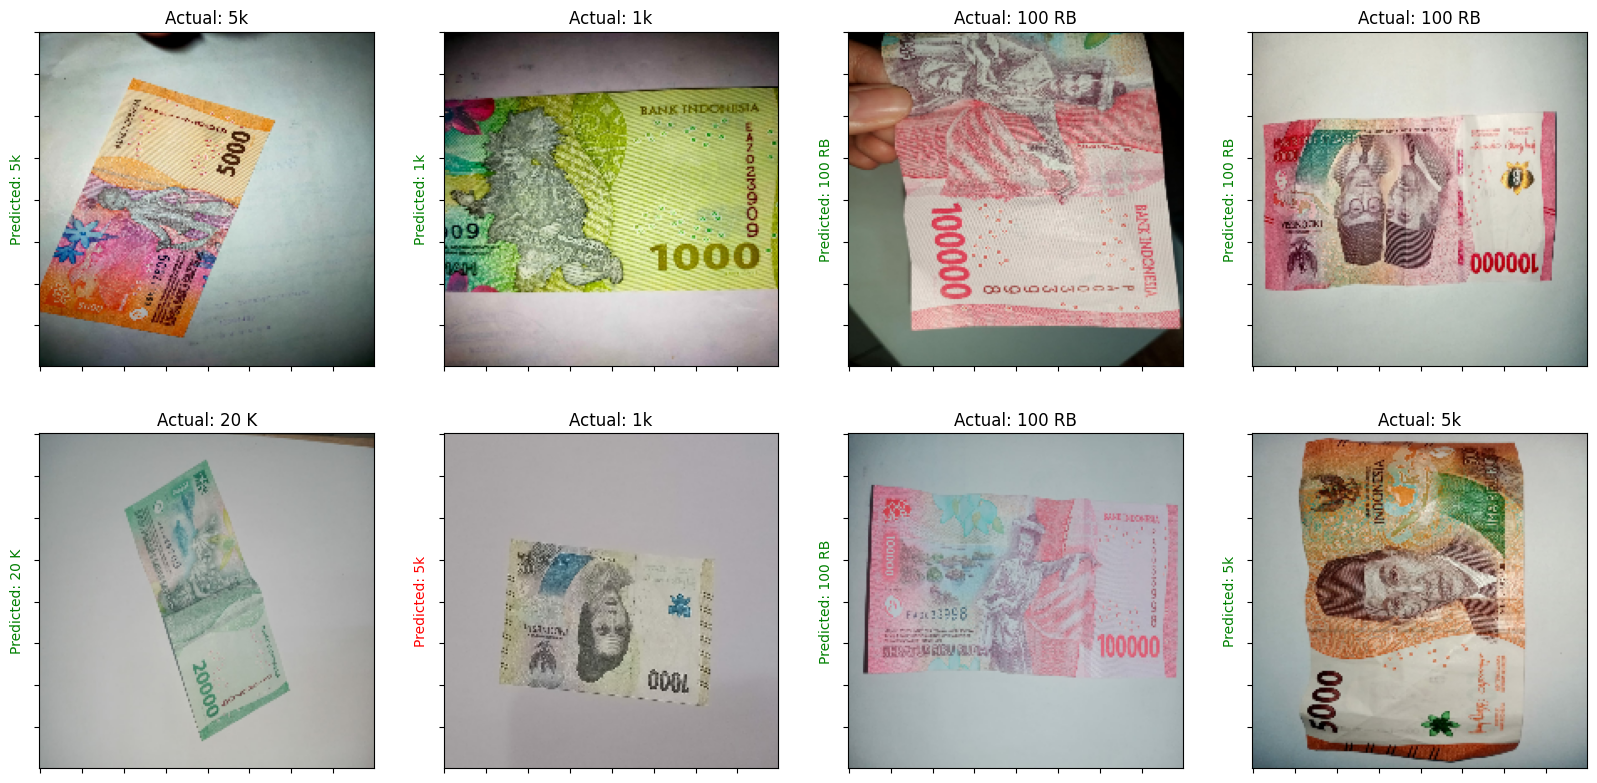

In [28]:
plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])

        predicted_axis_color = 'green' if currency_nominal[labels[i]] == currency_nominal[np.argmax(score)] else 'red'

        plt.title('Actual: ' + currency_nominal[labels[i]])
        plt.ylabel('Predicted: ' + currency_nominal[np.argmax(score)], fontdict={'color': predicted_axis_color})

        plt.gca().axes.xaxis.set_ticklabels([])
        plt.gca().axes.yaxis.set_ticklabels([])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


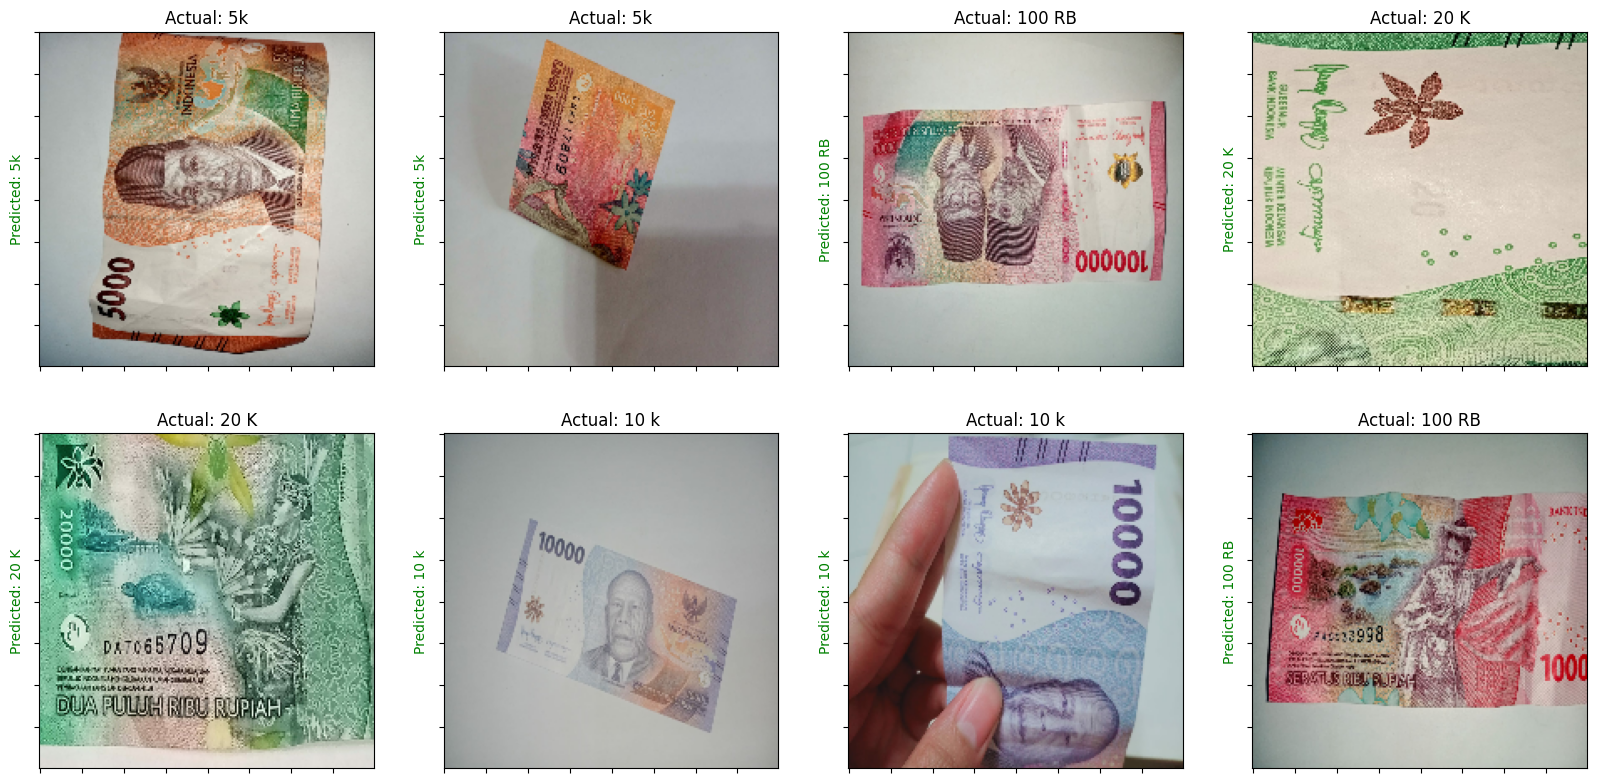

In [29]:
plt.figure(figsize=(20, 20))
for images, labels in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])

        predicted_axis_color = 'green' if currency_nominal[labels[i]] == currency_nominal[np.argmax(score)] else 'red'

        plt.title('Actual: ' + currency_nominal[labels[i]])
        plt.ylabel('Predicted: ' + currency_nominal[np.argmax(score)], fontdict={'color': predicted_axis_color})

        plt.gca().axes.xaxis.set_ticklabels([])
        plt.gca().axes.yaxis.set_ticklabels([])